Using code from [MedicalZooPytorch](https://github.com/black0017/MedicalZooPytorch)

In [458]:
import glob
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage

## Data paths and cv-split

In [6]:
fold = 0
df = pd.read_csv('../input/train_labels_folds-v1.csv')
df_train = df[df.fold != fold]
df_val = df[df.fold == fold]

df_train.head()

,BraTS21ID,MGMT_value,fold
0,0,1,2
1,2,1,2
2,3,0,1
3,5,1,2
5,8,1,3


In [9]:
npy_dir = '../input/registered_cases/train/'
sample_fns_train = [os.path.join(npy_dir, str(_id).zfill(5) + '.npy') for _id in df_train.BraTS21ID.values]
lbls_train = list(df_train.MGMT_value.values)

sample_fns_val = [os.path.join(npy_dir, str(_id).zfill(5) + '.npy') for _id in df_val.BraTS21ID.values]
lbls_val = list(df_val.MGMT_value.values)

## 3D MRI augmentations

In [540]:
class RandomChoice(object):
    """
    choose a random tranform from list an apply
    transforms: tranforms to apply
    p: probability
    """

    def __init__(self, transforms=[],
                 p=0.5):
        self.transforms = transforms
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        t = random.choice(self.transforms)
        return t(sample)
    
class ComposeTransforms(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms=[],
                 p=0.9):
        self.transforms = transforms
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        for t in self.transforms:
            sample = t(sample)
        return sample
    
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import gaussian_filter

def stack_seg_2_image(sample):
    image = sample['image']
    seg = sample['segmentation']
    channels = [chan for chan in image]
    channels.append(seg)
    return np.stack(channels, axis=3)

def elastic_transform_3d(sample, alpha=1, sigma=20, c_val=0.0, method="linear"):
    """
    :param sample: dict of image and seg
    :param alpha: scaling factor of gaussian filter
    :param sigma: standard deviation of random gaussian filter
    :param c_val: fill value
    :param method: interpolation method. supported methods : ("linear", "nearest")
    :return: deformed image and/or label
    """
    img_numpy = sample['image'].copy()
    label = sample['segmentation'] if 'segmentation' in sample else None
    shape = img_numpy.shape
    
    # Define 3D coordinate system
    coords = np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2])

    # Interpolated images
    chan_intrps = [RegularGridInterpolator(coords, img_numpy[:,:,:,chan],
                                        method=method,
                                        bounds_error=False,
                                        fill_value=c_val) for chan in range(shape[3])]

    #Get random elastic deformations
    dx = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dy = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dz = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha

    # Define sample points
    x, y, z = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]

    indices = np.reshape(x + dx, (-1, 1)), \
              np.reshape(y + dy, (-1, 1)), \
              np.reshape(z + dz, (-1, 1))

    # Interpolate 3D image image
    img_numpy = np.stack([chan_intrp(indices).reshape((shape[0],shape[1],shape[2])) 
                          for chan_intrp in chan_intrps], axis=3).astype(np.float32)

    # Interpolate labels
    if label is not None:
        lab_intrp = RegularGridInterpolator(coords, label,
                                            method="nearest",
                                            bounds_error=False,
                                            fill_value=0)

        label = lab_intrp(indices).reshape(shape[0],shape[1],shape[2]).astype(label.dtype)
        sample['segmentation'] = label
    
    sample['image'] = img_numpy
    return sample


class ElasticTransform(object):
    def __init__(self, p=0.5, alpha=1, sigma=20, c_val=0.0, method="linear"):
        self.p = p
        self.alpha = alpha
        self.sigma = sigma
        self.c_val = c_val
        self.method = method

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return elastic_transform_3d(sample, self.alpha, self.sigma, self.c_val, self.method)
    
def random_noise(sample, mean=0, std=0.001, eps=1e-6):
    im = sample['image'].copy()
    noise = np.random.normal(mean, std, im.shape)
    sample['image'] = np.where(im > eps, im + noise, im)
    return sample


class GaussianNoise(object):
    def __init__(self, p=0.5, mean=0, std=0.001):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        
        return random_noise(sample, self.mean, self.std)
    
def random_crop_to_size(sample, crop_sz):
    
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    shape = im.shape
    
    width, height, depth = crop_sz
    d = np.random.randint(0, shape[0] - depth - 1)
    x = np.random.randint(0, shape[1] - width - 1)
    y = np.random.randint(0, shape[2] - height - 1)
    
    im = im[d:d+depth, x:x+width, y:y+height,:]
    seg = seg[d:d+depth, x:x+width, y:y+height]
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample

class RandomCropToSize(object):
    
    def __init__(self, crop_sz=(200,200,95)):
        self.crop_sz = crop_sz

    def __call__(self, sample):
        return random_crop_to_size(sample, self.crop_sz)
    
def random_flip_lr(sample):
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    im = im[:,:,::-1,:]
    seg = seg[:,:,::-1]
    
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample

class RandomFlipLR(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_flip_lr(sample)

def random_channel_drop(sample):
    im = sample['image'].copy()
    c = im.shape[3]
    drop_ch = random.randint(0, c-1)
    im[:,:,:,drop_ch] = 0. if random.random() > 0.5 else 1.0
    sample['image'] = im
    return sample
    
class RandomChannelDrop(object):
    def __init__(self, p=0.05):
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_channel_drop(sample)

def random_rotate3D(sample, min_angle, max_angle):
    """
    Returns a random rotated image and seg map in sample dict
    :param sample: ds sample dict
    :param min_angle: in degrees
    :param max_angle: in degrees
    :return: sample
    """
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    assert min_angle < max_angle, "min should be less than max val"
    assert min_angle > -360 or max_angle < 360
    all_axes = [(1, 0), (1, 2), (0, 2)]
    
    angle = np.random.randint(low=min_angle, high=max_angle + 1)
    axes_random_id = np.random.randint(low=0, high=len(all_axes))
    axes = all_axes[axes_random_id]
    
    im = ndimage.interpolation.rotate(im , angle, axes=axes, reshape=False)
    
    seg = ndimage.rotate(seg.astype(np.float32), angle, axes=axes, reshape=False)
    
    # seg back to binary float values
    seg = np.where(seg < 0.5, 0, 1.)
    
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample


class RandomRotation(object):
    def __init__(self, min_angle=-10, max_angle=10, p=0.5):
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_rotate3D(sample, self.min_angle, self.max_angle)

## Dataset

In [631]:
class BraTS2021(Dataset):
    """
    Dataset for BraTS2021 challenge - Includes tasks 1 and 2
    """

    def __init__(self, mode, 
                 npy_fns_list,
                 label_list=[],
                 augmentations=None,
                 volume_normalize=True):
        """
        :param mode: 'train','val','test'
        :param npy_fns_list: list of numpy array paths
        :param label_list: list of binary label integers
        :param augmentations: 3D augmentations
        :param volume_normalize: z-score normalize each channel in sample
        """
        self.mode = mode
        self.augmentations = augmentations
        self.volume_normalize = volume_normalize
        
        self.seg_fn_list = []
        self.fn_list = npy_fns_list
        self.label_list = label_list
        
        if self.mode != "test":
            fn_list_with_seg = []
            label_list_with_seg = []
            for fn, lbl in zip(npy_fns_list, label_list):
                fn_seg = str(fn).replace('.npy', '_seg.npy')
                if os.path.exists(fn_seg) and os.path.exists(fn):
                    fn_list_with_seg.append(fn)
                    self.seg_fn_list.append(fn_seg)
                    label_list_with_seg.append(int(lbl))
            
            # update fn list and exclude ones that don't have seg map
            self.fn_list = fn_list_with_seg
            self.label_list = label_list_with_seg
            assert len(self.fn_list) == len(self.seg_fn_list) == len(self.label_list)
        
        ########################
        #### Sanity checks #####
        
        assert len(self.fn_list) > 0
        
        # Check one sample
        one_sample = np.load(self.fn_list[0])
        assert len(one_sample.shape) == 4
        d,x,y,c = one_sample.shape
        self.full_vol_dim = (x,y,d)
        self.channels = c
        
        # Check one seg map
        if len(self.seg_fn_list) > 0:
            one_seg_sample = np.load(self.seg_fn_list[0])
            assert len(one_seg_sample.shape) == 3
            seg_d,seg_x,seg_y = one_seg_sample.shape
            assert seg_d == d
            assert seg_x == x
            assert seg_y == y
            
        #### Sanity checks #####
        ########################
        
        # shuffle samples
        if self.mode != "test":
            all_lists = list(zip(self.fn_list, self.seg_fn_list, self.label_list))
            random.shuffle(all_lists)
            self.fn_list, self.seg_fn_list, self.label_list = zip(*all_lists)
        
    def __len__(self):
        return len(self.fn_list)

    def __getitem__(self, index):
        sample = np.load(self.fn_list[index]).astype(np.float32)
        out_dict = {
            'BraTSID' : int(os.path.basename(self.fn_list[index]).split('.')[0]),
            'image' : sample
        }
        if self.mode != "test":
            seg = np.load(self.seg_fn_list[index])
            # set seg to binary values
            seg = (seg > 0).astype(np.float32)
            lbl = self.label_list[index]
            out_dict['segmentation'] = seg 
            out_dict['label'] = lbl
            
            if self.augmentations:
                out_dict = self.augmentations(out_dict)
        
        # z-score norm each channel - done after augmentations
        if self.volume_normalize:
            sample = out_dict['image']
            sample_mean = np.mean(sample, axis=tuple([0,1,2]))
            sample_std = np.std(sample, axis=tuple([0,1,2])) + 1e-6
            sample = (sample - sample_mean) / sample_std
            out_dict['image'] = sample
            out_dict['mean'] = sample_mean
            out_dict['std'] = sample_std
        else:
            out_dict['mean'] = np.array([0 for _ in range(sample.shape[3])])
            out_dict['std'] = np.array([1. for _ in range(sample.shape[3])])
        
        # convert values to torch and arrays
        for key, val in out_dict.items():
            if key == 'label':
                out_dict[key] = np.array(val)
            elif key == 'BraTSID':
                out_dict[key] = np.array(val)
            else:
                out_dict[key] = torch.FloatTensor(val.copy())
            
        return out_dict

In [632]:
crop_sz = (200,200,95)

augmentations = ComposeTransforms([
    ElasticTransform(p=0.1),
    RandomRotation(p=0.5),
    RandomCropToSize(crop_sz=crop_sz),
    GaussianNoise(p=0.2, mean=0, std=0.001),
    RandomFlipLR(p=0.5),
    RandomChannelDrop(p=0.01),
], p=1.0)

train_ds = BraTS2021(
    mode='train', 
    npy_fns_list=sample_fns_train, 
    label_list=lbls_train,
    augmentations=augmentations,
    volume_normalize=True
)

In [633]:
%%time
sample = train_ds.__getitem__(1)

CPU times: user 706 ms, sys: 90.6 ms, total: 796 ms
Wall time: 1.02 s


## Visualization

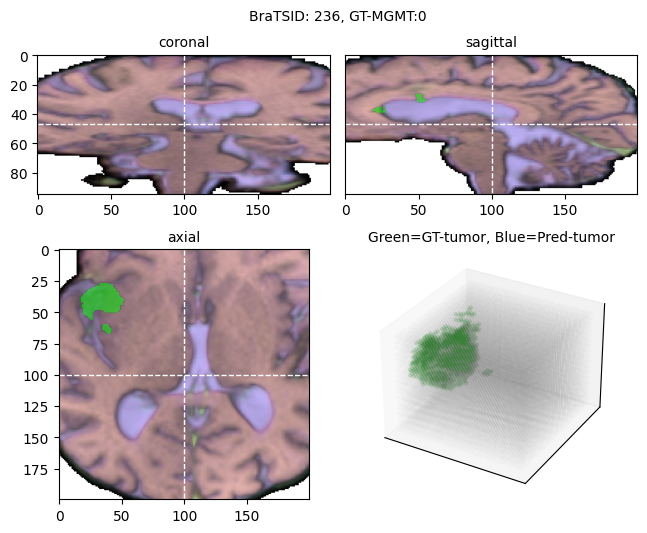

In [637]:
def make_bg_transparent(im, bg_th=0.0, set_to_color=None):
    # create transparency alpha channel
    # convert image to RGBA
    if len(im.shape) == 3:
        alpha_c = (np.sum(im[:,:,:],axis=2) > bg_th).astype(im.dtype)
        c1,c2,c3 = cv2.split(im)
    else:
        alpha_c = (im[:,:] > bg_th).astype(im.dtype)
        c1,c2,c3 = im.copy(), im.copy(), im.copy()
    if set_to_color is not None:
        zeros = np.zeros_like(c1)
        if set_to_color == 'green':
            merged = np.stack([zeros,c2,zeros,alpha_c], axis=-1)
        elif set_to_color == 'red':
            merged = np.stack([c1,zeros,zeros,alpha_c], axis=-1)
        else:
            merged = np.stack([zeros,zeros,c3,alpha_c], axis=-1)
    else:
        merged = np.stack([c1,c2,c3,alpha_c], axis=-1)
    return merged

def to_3d_points(im, th=0.0, downsample=5):
    xs,ys,ds = [],[],[]
    if len(im.shape) == 4:
        im3d = np.sum(im,axis=3)
    else:
        im3d = im
    depth,width,height = im3d.shape
    step_vol = downsample**3
    for x in range(0, width - downsample, downsample):
        for y in range(0, height - downsample, downsample):
            for d in range(0, depth - downsample, downsample):
                if (np.sum(im3d[d:d+downsample, x:x+downsample, y:y+downsample]) / step_vol) > th:
                    xs.append(x + (downsample//2))
                    ys.append(y + (downsample//2))
                    ds.append(d + (downsample//2))
    return np.array(xs), np.array(ys), np.array(ds)

def adjust_saturation(img, sat_scale=0.3):
    hsv_im = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    (h, s, v) = cv2.split(hsv_im)
    s = s*sat_scale
    s = np.clip(s,0,255)
    hsv_im = np.stack([h,s,v],axis=2).astype(np.uint8)
    return cv2.cvtColor(hsv_im, cv2.COLOR_HSV2RGB) / 255.

def show_mri_sample(sample, pred_mask=None, pred_lbl=None):
    """ Plot sample in three projections """
    plt.close('all')
    #f, axs = plt.subplots(2,2,figsize=(6,5))
    f = plt.figure(figsize=(6,5))
    alpha=0.5
    image_alpha=1.0
    
    im = sample['image'].numpy()
    mean = sample['mean'].numpy()
    std = sample['std'].numpy()
    im = (im * std) + mean
    seg = sample['segmentation'].numpy() if 'segmentation' in sample else None
    
    title = f'BraTSID: {sample["BraTSID"]}'
    if 'label' in sample:
        title += f', GT-MGMT:{sample["label"]}'
    if pred_lbl is not None:
        title += f', Pred-MGMT:{pred_lbl}'
    
    f.suptitle(title, fontsize=10)
    
    d,x,y,c = im.shape
    coronal_ax = f.add_subplot(2,2,1)
    coronal_ax.set_title('coronal', fontsize=10)
    coronal_ax.imshow(make_bg_transparent(adjust_saturation(im[::-1,x//2,:,:])), alpha=image_alpha)
    
    sagittal_ax = f.add_subplot(2,2,2)
    sagittal_ax.set_title('sagittal', fontsize=10)
    sagittal_ax.get_yaxis().set_visible(False)
    sagittal_ax.imshow(make_bg_transparent(adjust_saturation(im[::-1,:,y//2,:])), alpha=image_alpha)
    
    axial_ax = f.add_subplot(2,2,3)
    axial_ax.set_title('axial', fontsize=10)
    axial_ax.imshow(make_bg_transparent(adjust_saturation(im[d//2,:,:,:])), alpha=image_alpha)
    
    proj_ax = f.add_subplot(2, 2, 4, projection='3d')
    proj_ax.scatter(*to_3d_points(im), color='gray', alpha=0.015, s=5, depthshade=False)
    proj_ax.set_title('Green=GT-tumor, Blue=Pred-tumor', fontsize=10)
    proj_ax.set_xticks([])                               
    proj_ax.set_yticks([])                               
    proj_ax.set_zticks([])
    
    if seg is not None:
        coronal_ax.imshow(make_bg_transparent(seg[::-1,x//2,:], set_to_color='green'), alpha=alpha)
        sagittal_ax.imshow(make_bg_transparent(seg[::-1,:,y//2], set_to_color='green'), alpha=alpha)
        axial_ax.imshow(make_bg_transparent(seg[d//2,:,:], set_to_color='green'), alpha=alpha)
        proj_ax.scatter(*to_3d_points(seg), color='green', s=5, alpha=0.1)
    
    if pred_mask is not None:
        coronal_ax.imshow(make_bg_transparent(pred_mask[::-1,x//2,:], set_to_color='blue'), alpha=alpha)
        sagittal_ax.imshow(make_bg_transparent(pred_mask[::-1,:,y//2], set_to_color='blue'), alpha=alpha)
        axial_ax.imshow(make_bg_transparent(pred_mask[d//2,:,:], set_to_color='blue'), alpha=alpha)
        proj_ax.scatter(*to_3d_points(pred_mask), color='blue', s=5, alpha=0.1)
        
    # draw axial lines
    coronal_ax.plot([0,x-1],[d//2,d//2],'--',color='white', linewidth=1) # coronal horizontal
    coronal_ax.plot([x//2,x//2],[0,d-1],'--',color='white', linewidth=1) # coronal vertical
    sagittal_ax.plot([0,y-1],[d//2,d//2],'--',color='white', linewidth=1) # sagittal horizontal
    sagittal_ax.plot([y//2,y//2],[0,d-1],'--',color='white', linewidth=1) # sagittal vertical
    axial_ax.plot([0,y-1],[x//2,x//2],'--',color='white', linewidth=1) # axial horizontal
    axial_ax.plot([x//2,x//2],[0,y-1],'--',color='white', linewidth=1) # axial vertical
    
    plt.subplots_adjust(left=0.00,top=1.,right=1.,bottom=0.00, wspace=0.05, hspace=0.00)
    plt.show()
    
show_mri_sample(sample)

In [635]:
from torch.utils.data import DataLoader

dl_args = {
    'batch_size': 4,
    'shuffle': True,
    'num_workers': 0
}

train_generator = DataLoader(train_ds, **dl_args)

In [636]:
batch = None
for batch in train_generator:
    break
batch

{'BraTSID': tensor([300, 194, 188, 682]),
 'image': tensor([[[[[-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            ...,
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282]],
 
           [[-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            ...,
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282]],
 
           [[-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            ...,
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282]],
 
           ...,
 
           [[-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
            [-1.3372, -1.2082, -1.1282],
          